In [7]:
import os
import tarfile

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.io

from PIL import Image

In [8]:
# with tarfile.open(r'<path>', 'r:gz') as tar:
#     tar.list()
#     tar.extractall(path='./data')

## 1 Load & Preprocess Data


In [9]:
class FlowerDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        # Load image labels
        mat = scipy.io.loadmat(label_file)
        self.labels = mat['labels'].flatten() - 1 # converts 1-based idx in matlab to 0-based idx in python
        
        # Load image file names
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.image_files.sort()
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.long)
        

In [10]:
image_size = 64
batch_size = 64

transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), # resize image to (image_size x image_size)
        transforms.ToTensor(), # convert arrays to tensors
        transforms.Normalize([.5, .5, .5], [.5, .5, .5]), # normalize pixels (pixel - mean) / STD -> mean & SD for R,G,B is 0.5
    ]
)

img_dir = "./data/jpg"
label_file = "imagelabels.mat"

dataset = FlowerDataset(img_dir, label_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 2 Define Conditional GAN models


In [11]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, label_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_dim) # create embedding layer to map label indices (102 different flowers)
        self.model = nn.Sequential( # focus on linear layers only first
            nn.Linear(latent_dim + label_dim, 256), # input to CondGenerator is noise & label, 256 output
            nn.ReLU(), # introduce non-linearity
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3* image_size * image_size), # output is 64 x 64 vector
            nn.Tanh() # good practice to add at end to further normalize inputs
        )
    
    def forward(self, noise, labels):
        label_emb = self.label_embedding(labels) # map label indices (102 different flowers) by passing to embedding layer
        generator_input = torch.cat((noise, label_emb), -1)  # concat tensors, -1 means combine by col to prep input
        img = self.model(generator_input)
        img = img.view(img.size(0), 3, image_size, image_size) # reshape to (batchsize, RGB, image_size, image_size) (64, 3, 64, 64)
        return img

class ConditionalDiscriminator(nn.Module):
    def __init__(self, label_dim, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, label_dim) # create embedding layer to map label indices (102 different flowers)
        self.model = nn.Sequential(
            nn.Linear(3 * image_size * image_size + label_dim, 1024), # input to Discriminator is output from Generator + label_dim
            nn.LeakyReLU(0.2), # to prevent vanishing gradient
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # squeeze output between 0 and 1 - fake vs real label
        )
    
    def forward(self, img, labels): # propagate img from generator
        img_flat = img.view(img.size(0), -1) # flatten from 3 x 64 x 64 to 64 x 64
        label_emb = self.label_embedding(labels)
        discriminator_input = torch.cat((img_flat, label_emb), -1) # concat img_flat & label_emb by col
        validity = self.model(discriminator_input) # determine if img is valid or not
        return validity
           

## 3 Model Init & Training


In [12]:
# Parameters
lr = 0.0002
latent_dim = 100 # noise vector dim
label_dim = 50 # if equal num_classes, may overfit
num_classes = 102
n_epochs = 100

# Model Init
generator = ConditionalGenerator(latent_dim, label_dim, num_classes)
discriminator = ConditionalDiscriminator(label_dim, num_classes)

# Loss & Optim
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=0.0002) 
optim_d = optim.Adam(discriminator.parameters(), lr=0.0001)

In [13]:
# Training Loop
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        label_emb = labels
        real_imgs = imgs
        
        # create real & fake data ground truths
        real_labels = torch.ones(imgs.size(0), 1) # real label means 1, imgs.size(0) is the batch_size
        fake_labels = torch.zeros(imgs.size(0), 1) # fake label means 0
    
        # Train Discriminator
        optim_d.zero_grad() # zero the gradient to prevent accumulation
        real_output = discriminator(real_imgs, label_emb) # pass to forward(img, labels)
        real_loss = criterion(real_output, real_labels)
        
        noise = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(noise, label_emb).detach() # detach to prevent gradient update
        fake_output = discriminator(fake_imgs, label_emb)
        fake_loss = criterion(fake_output, fake_labels)
        
        d_loss_total = real_loss + fake_loss
        d_loss_total.backward() # backprop to calc grad
        optim_d.step() # grad desc to update weights
        
        # Train Generator
        optim_g.zero_grad()
        
        noise = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(noise, label_emb)
        fake_output = discriminator(fake_imgs, label_emb)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward() # backprop to calc grad
        optim_g.step() # grad desc to update grad
        
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i}/{len(dataloader)}], "
                f"D Loss: {d_loss_total.item():.4f}, G Loss: {g_loss.item():.4f}")
        
         
        

Epoch [1/100], Step [0/128], D Loss: 1.3950, G Loss: 0.6877
Epoch [1/100], Step [50/128], D Loss: 0.5863, G Loss: 0.9392
Epoch [1/100], Step [100/128], D Loss: 0.1471, G Loss: 2.1927
Epoch [2/100], Step [0/128], D Loss: 1.2733, G Loss: 0.5551
Epoch [2/100], Step [50/128], D Loss: 0.4485, G Loss: 1.8142
Epoch [2/100], Step [100/128], D Loss: 1.2935, G Loss: 0.5654
Epoch [3/100], Step [0/128], D Loss: 0.1531, G Loss: 3.0207
Epoch [3/100], Step [50/128], D Loss: 0.2273, G Loss: 2.1278
Epoch [3/100], Step [100/128], D Loss: 0.1727, G Loss: 5.3544
Epoch [4/100], Step [0/128], D Loss: 0.9397, G Loss: 2.7385
Epoch [4/100], Step [50/128], D Loss: 0.8343, G Loss: 1.3350
Epoch [4/100], Step [100/128], D Loss: 0.4997, G Loss: 2.6900
Epoch [5/100], Step [0/128], D Loss: 0.0866, G Loss: 4.0555
Epoch [5/100], Step [50/128], D Loss: 1.4185, G Loss: 1.5007
Epoch [5/100], Step [100/128], D Loss: 0.8452, G Loss: 3.0772
Epoch [6/100], Step [0/128], D Loss: 0.9343, G Loss: 1.4779
Epoch [6/100], Step [50/1

In [14]:
# generator_path = './data/generator.pth'
# discriminator_path = './data/discriminator.pth'

# torch.save(generator.state_dict(), generator_path)
# torch.save(discriminator.state_dict(), discriminator_path)

# generator.load_state_dict(torch.load(generator_path))
# discriminator.load_state_dict(torch.load(discriminator_path))

# generator.eval()
# discriminator.eval()

## 4 Model Data Generation & Evaluation


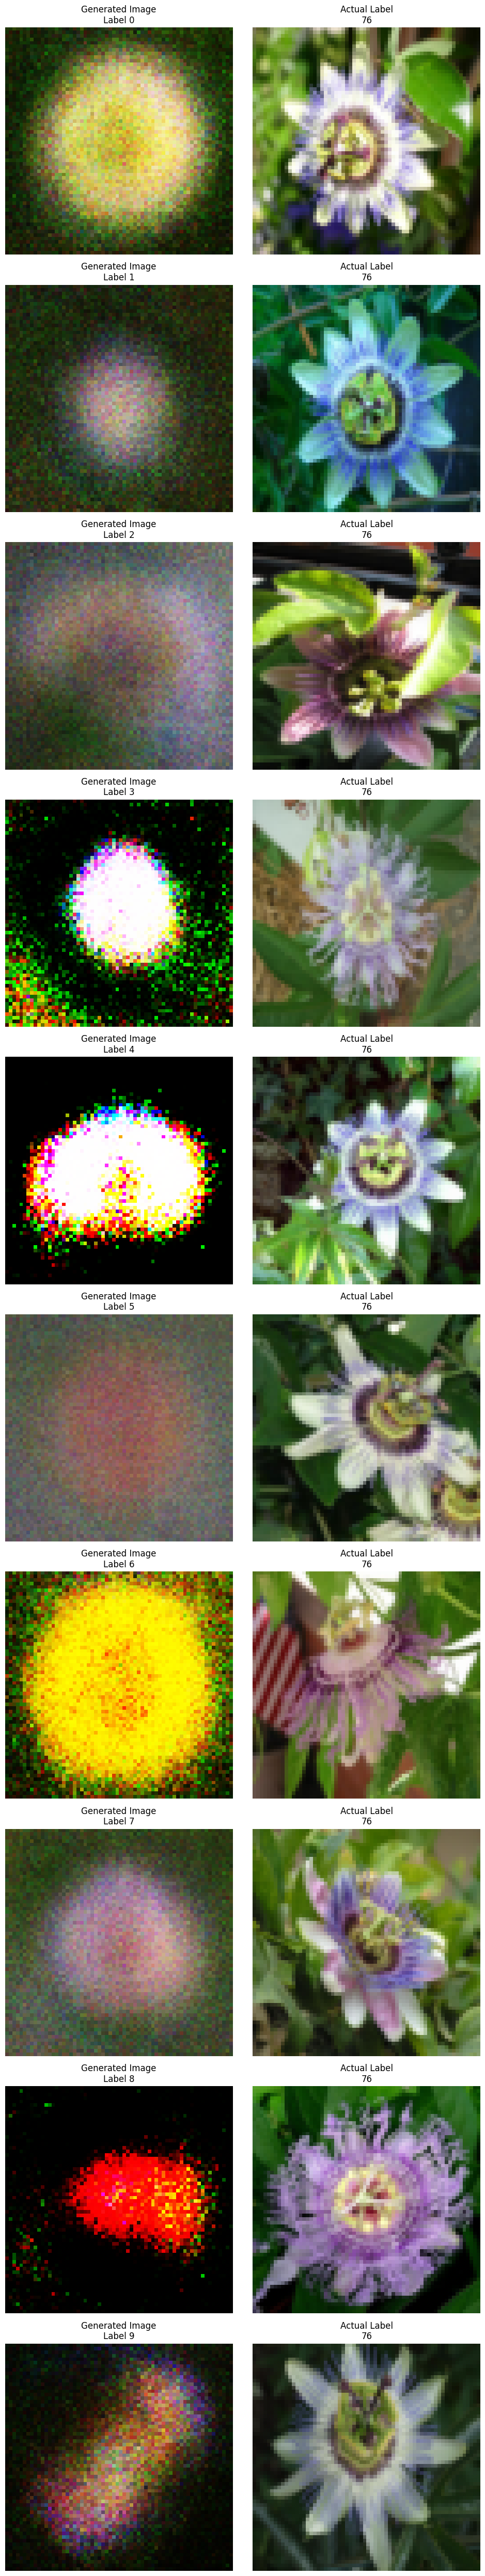

In [41]:
def generate_and_display_images(generator, latent_dim, num_classes, dataset, num_images=10):
    generator.eval()  # Set generator to eval mode
    
    # Create a figure with multiple subplots: 10 rows and 2 columns
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
    for i in range(num_images):
        label = i % num_classes  # Use a different label for each row (this can be adjusted based on your need)
        
        # Generate random noise
        noise = torch.randn(1, latent_dim)  # Generate random noise for each image
        label_tensor = torch.tensor([label], dtype=torch.long)  # Convert label to tensor
        
        # Generate Image
        with torch.no_grad():  # Speed up computations by disabling gradient calculation
            generated_image = generator(noise, label_tensor)
        
        # Convert generated image to numpy and set dimensions (channel x height x width -> height x width x channel)
        generated_img = generated_image.squeeze().permute(1, 2, 0).numpy()
        
        # Scale image to [0, 1] range
        generated_img = (generated_img + 1) / 2
        
        # Plot generated image
        axes[i, 0].imshow(generated_img)
        axes[i, 0].axis('off')  # Turn off axes for better visual presentation
        axes[i, 0].set_title(f"Generated Image\nLabel {label}")
        
        # Fetch the actual image corresponding to the label from the dataset
        actual_image, actual_label = dataset[label]  # Get image and label from dataset
        
        # Convert the actual image tensor to a NumPy array for plotting
        actual_image = actual_image.permute(1, 2, 0).numpy()  # Convert to HWC format (Height x Width x Channels)
        actual_image = (actual_image + 1) / 2  # Scale image to [0, 1] range

        # Plot the actual image
        axes[i, 1].imshow(actual_image)
        axes[i, 1].axis('off')  # Turn off axes for better visual presentation
        axes[i, 1].set_title(f"Actual Label\n{actual_label.item()}")
    
    plt.tight_layout()  # Ensure there is no overlap between images
    plt.show()

# Example usage
generate_and_display_images(generator, latent_dim, num_classes, dataset, num_images=10)